In [1]:
import xarray as xr
import numpy as np
import os

# 1. 路径设置 (保持你之前的路径)
file_path = r'../data_generators/dataset_yrd.nc'

# 2. 读取数据
ds = xr.open_dataset(file_path)

# --- A. 基础信息输出 ---
print("=== 维度信息 ===")
print(f"时间维度 (time): {ds.sizes['time']}")
print(f"站点维度 (station): {ds.sizes['station']}")

# 获取所有变量名 (PM2.5, O3, t2m, etc.)
var_names = list(ds.data_vars)
print(f"\n包含的变量: {var_names}")


# 如果你想把所有变量堆叠成一个大数组用于训练模型
all_data_list = []
for var in var_names:
    all_data_list.append(ds[var].values)

# stack 堆叠: axis=-1 表示在最后一个维度增加变量维
# 结果形状: (70128, 127, 10)
full_time_series_array = np.stack(all_data_list, axis=-1)

print(f"\n=== 最终合并的时间序列数组 ===")
print(f"Shape: {full_time_series_array.shape}")
print("含义: (时间步, 站点数, 特征变量数)")
print(f"其中特征顺序对应: {var_names}")

ds.close()

=== 维度信息 ===
时间维度 (time): 70128
站点维度 (station): 127

包含的变量: ['PM2.5', 'O3', 't2m', 'd2m', 'sp', 'tp', 'blh', 'msdwswrf', 'u100', 'v100']

=== 最终合并的时间序列数组 ===
Shape: (70128, 127, 10)
含义: (时间步, 站点数, 特征变量数)
其中特征顺序对应: ['PM2.5', 'O3', 't2m', 'd2m', 'sp', 'tp', 'blh', 'msdwswrf', 'u100', 'v100']


In [2]:
import pandas as pd
import plotly.express as px

df = pd.read_csv('../data_generators/stations_yrd.csv')
micro_name = list(df["station_id"])

In [3]:
import pandas as pd
import plotly.express as px

fig = px.scatter(
    df,
    x="lon",
    y="lat",
    text="station_id",
    hover_data=["station_name", "city"]
)
fig.update_traces(textposition='top center')
fig.show()

# 数据展示

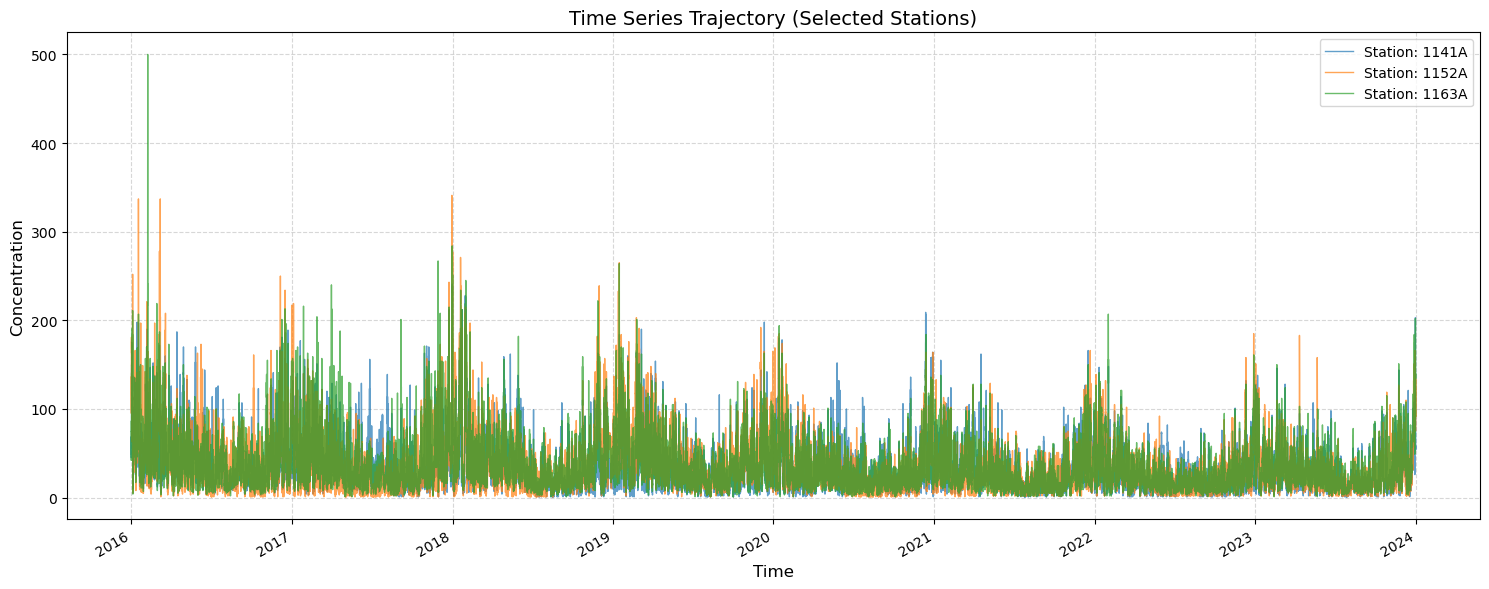

In [34]:
import matplotlib.pyplot as plt

num_stations_to_plot = 3
pm25 = ds['PM2.5']
o3 = ds['O3']
times = ds['time'].values
stations = ds['station'].values
# 方式 A: 随机选择站点
# selected_indices = np.random.choice(len(stations), num_stations_to_plot, replace=False)

# 方式 B: 手动指定前几个站点 (比较稳定，适合观察)
selected_indices = [0, 10, 20] # 比如第1个、第11个、第21个站点

# 创建画布
plt.figure(figsize=(15, 6))

# 循环绘制选定站点的曲线
for idx in selected_indices:
    station_name = stations[idx]
    # 提取该站点的 PM2.5 数据
    # .isel(station=idx) 按索引取
    station_data_o3 = o3.isel(station=idx).values
    station_data_pm25 = pm25.isel(station=idx).values
    
    plt.plot(times, station_data_pm25, label=f'Station: {station_name}', alpha=0.7, linewidth=1)

# 添加图表细节
plt.title('Time Series Trajectory (Selected Stations)', fontsize=14)
plt.ylabel('Concentration', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)

# 优化时间轴显示 (防止重叠)
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

# 算法处理

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import scipy
import seaborn as sns
import sklearn
import pysindy as ps 
from sklearn.linear_model import Lasso
from tools import get_positive_contributions, compute_entropy, print_equations, fit_sindy_sr3_robust, lift_time_delay, plot_station
from data_func import plot_clustered_kuramoto, generate_kuramoto_cluster_data_sin_cos
import warnings
from sklearn.exceptions import ConvergenceWarning

# 仅忽略收敛警告
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [6]:
x_data = pm25.values
x_data.shape

(70128, 127)

In [22]:
ide = ps.IdentityLibrary()
n_delays = 1
H, new_names = lift_time_delay(x_data, feature_names=micro_name, n_delays=n_delays, delay_interval=1)
H.shape, new_names

((70127, 254),
 ['1141A',
  '1142A',
  '1143A',
  '1144A',
  '1145A',
  '1147A',
  '1148A',
  '1149A',
  '1150A',
  '1151A',
  '1152A',
  '1153A',
  '1154A',
  '1155A',
  '1156A',
  '1157A',
  '1158A',
  '1159A',
  '1160A',
  '1162A',
  '1163A',
  '1164A',
  '1165A',
  '1166A',
  '1167A',
  '1168A',
  '1169A',
  '1170A',
  '1171A',
  '1172A',
  '1186A',
  '1188A',
  '1189A',
  '1190A',
  '1191A',
  '1192A',
  '1193A',
  '1194A',
  '1195A',
  '1196A',
  '1200A',
  '1201A',
  '1203A',
  '1204A',
  '1205A',
  '1206A',
  '1207A',
  '1209A',
  '1223A',
  '1224A',
  '1226A',
  '1227A',
  '1228A',
  '1230A',
  '1231A',
  '1232A',
  '1233A',
  '1234A',
  '1235A',
  '1236A',
  '1239A',
  '1240A',
  '1241A',
  '1247A',
  '1250A',
  '1252A',
  '1253A',
  '1255A',
  '1256A',
  '1257A',
  '1258A',
  '1259A',
  '1260A',
  '2869A',
  '2870A',
  '2871A',
  '2872A',
  '2873A',
  '2907A',
  '2921A',
  '2997A',
  '3002A',
  '3003A',
  '3010A',
  '3164A',
  '3195A',
  '3265A',
  '3266A',
  '3268A',
  '326

In [8]:
discrete_time = True
dt = 1
model, results = fit_sindy_sr3_robust(H, ide, new_names, penalty='l1', discrete_time=discrete_time, max_iter=500)

开始使用 L1 范数扫描 20 个参数...


100%|██████████| 20/20 [27:39<00:00, 82.95s/it]


最佳模型 (aic) | Penalty: l1
Param (Thr/Lam): 1.000e-01
Test MSE: 1.3708e+01
Complexity: 31236
(1141A)[k+1] = 0.573 1141A[k] + 0.005 1142A[k] + 0.089 1143A[k] + 0.029 1144A[k] + 0.076 1145A[k] + 0.136 1147A[k] + 0.044 1148A[k] + 0.012 1149A[k] + 0.015 1150A[k] + 0.001 1151A[k] + -0.007 1152A[k] + 0.007 1153A[k] + -0.016 1154A[k] + 0.008 1155A[k] + -0.003 1156A[k] + -0.012 1157A[k] + 0.003 1158A[k] + 0.002 1159A[k] + -0.015 1160A[k] + -0.009 1162A[k] + 0.030 1164A[k] + 0.005 1165A[k] + 0.015 1166A[k] + 0.031 1167A[k] + -0.012 1168A[k] + 0.018 1169A[k] + 0.006 1170A[k] + 0.042 1171A[k] + 0.002 1172A[k] + 0.015 1186A[k] + -0.005 1188A[k] + -0.002 1189A[k] + 0.019 1190A[k] + -0.013 1191A[k] + -0.006 1192A[k] + -0.002 1193A[k] + 0.002 1194A[k] + 0.016 1195A[k] + 0.007 1196A[k] + 0.015 1200A[k] + 0.011 1201A[k] + -0.002 1204A[k] + -0.001 1206A[k] + -0.010 1207A[k] + 0.012 1223A[k] + -0.004 1224A[k] + -0.004 1226A[k] + -0.007 1227A[k] + -0.019 1228A[k] + -0.001 1230A[k] + -0.015 1231A[k] + 0.008

In [9]:
model.score(H, t=dt)

0.9758203779804456

In [10]:
step_pred = 5
t = range(step_pred)
init_data = H[0,:]

if discrete_time:
    X_data_predicted = model.simulate(init_data,step_pred)
else:
    X_data_predicted = model.simulate(init_data,t) 

X_data_predicted.shape

(5, 254)

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_39913/2734313379.py:8: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



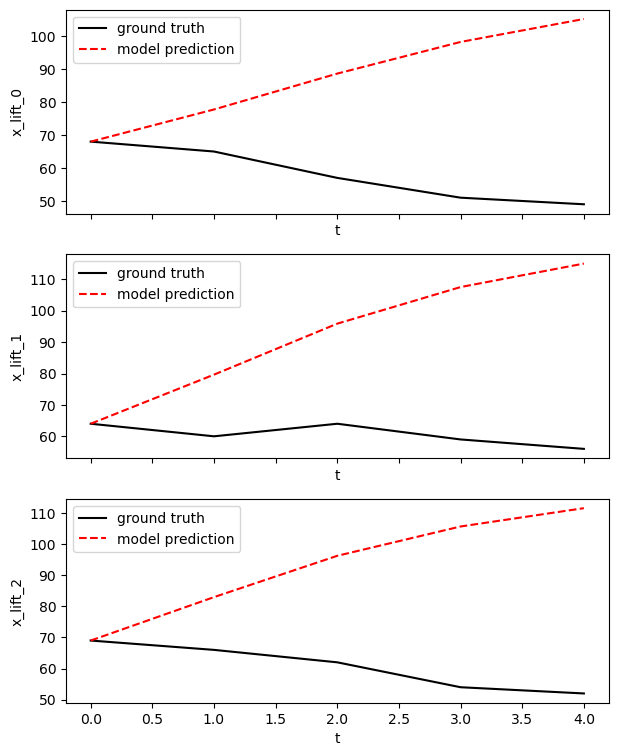

In [11]:
# 只看部分维度的多步预测
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(7, 9))
for i in range(3):
    axs[i].plot(H[:step_pred, i], "k", label="ground truth")
    axs[i].plot(X_data_predicted[:step_pred, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"x_lift_{}".format(i))
fig.show()

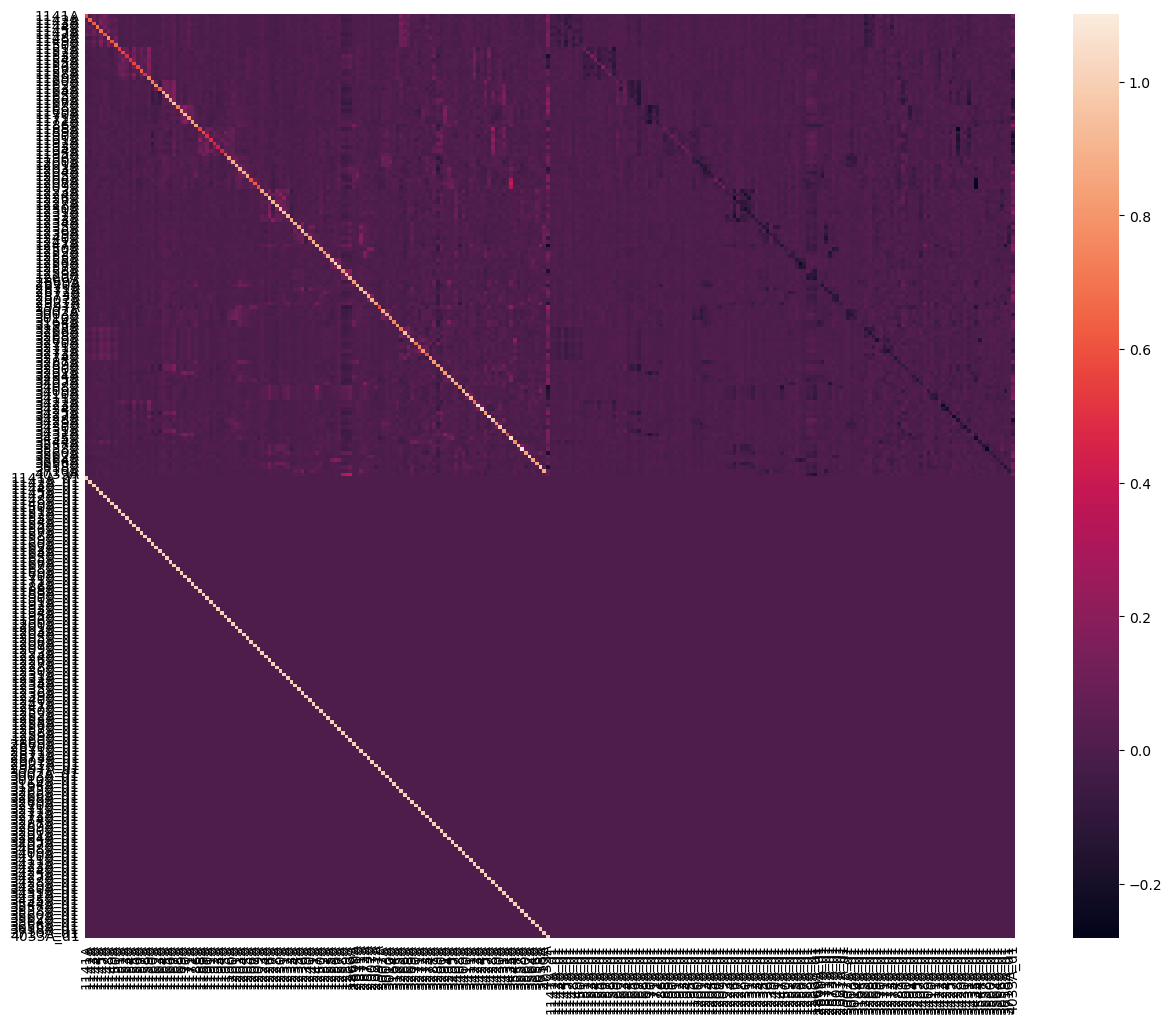

In [12]:
# 提取和处理系数矩阵
A = model.coefficients()
if discrete_time==False:
    A = scipy.linalg.expm(A)

# 只设置参数，不自动显示全部
plt.figure(figsize=(15, 12)) # 把画布搞大一点
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(A, xticklabels=new_names, yticklabels=new_names)
# 旋转横轴标签，避免重叠
plt.xticks(rotation=90)  # 旋转90度
plt.yticks(rotation=0)   # 纵轴保持水平
plt.show()

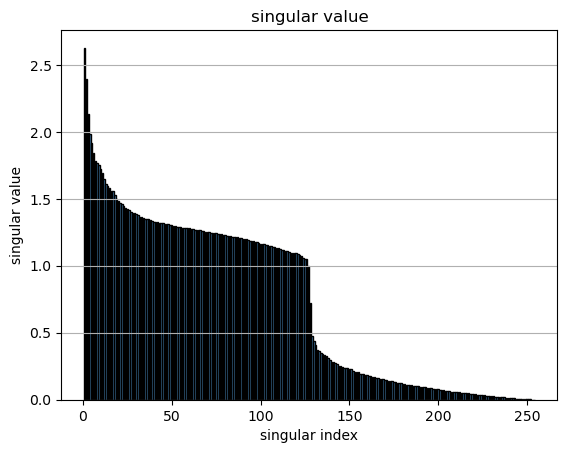

In [13]:
U,S,V = np.linalg.svd(A)
plt.figure()
plt.bar(np.arange(1, len(S)+1), S, color='steelblue', edgecolor='k')
plt.grid(True, axis='y')         
plt.xlabel('singular index')
plt.ylabel('singular value')
plt.title('singular value')
plt.show()

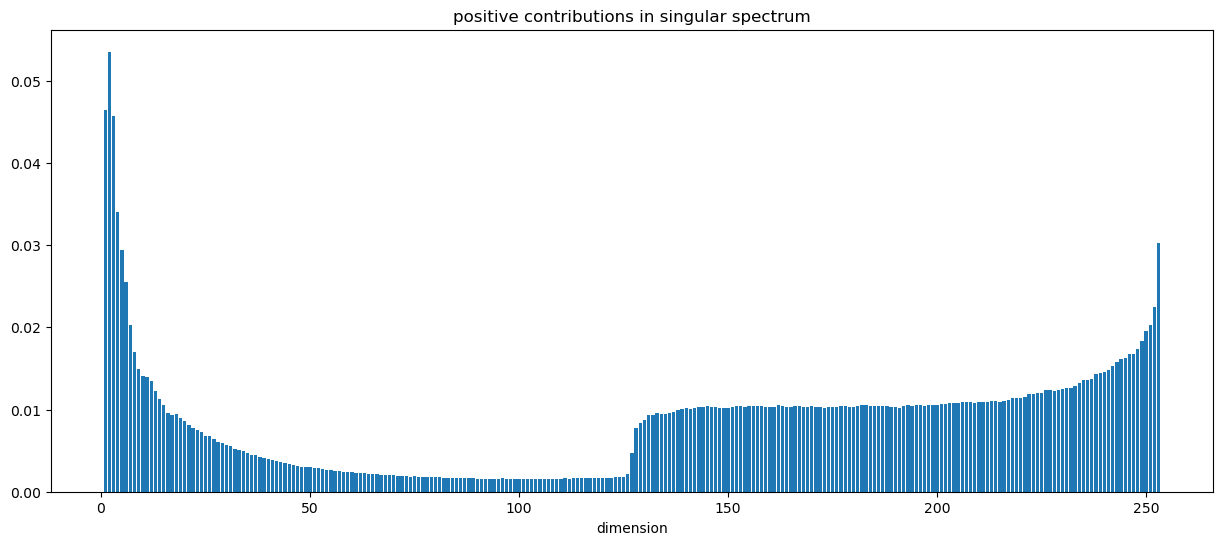

In [14]:
diff = get_positive_contributions(S)
#diff = diff[:50]
plt.figure(figsize=(15, 6))
plt.bar(range(1,len(diff)+1), diff) 
plt.xlabel('dimension')
plt.title('positive contributions in singular spectrum')
plt.show()

In [16]:
print(compute_entropy(diff))

7.56556401205046


In [17]:
rank = 3
S_macro = S[:rank]
delt_gamma = sum(S_macro) / rank - sum(S) / len(S)
print(delt_gamma)

1.6598885321794687


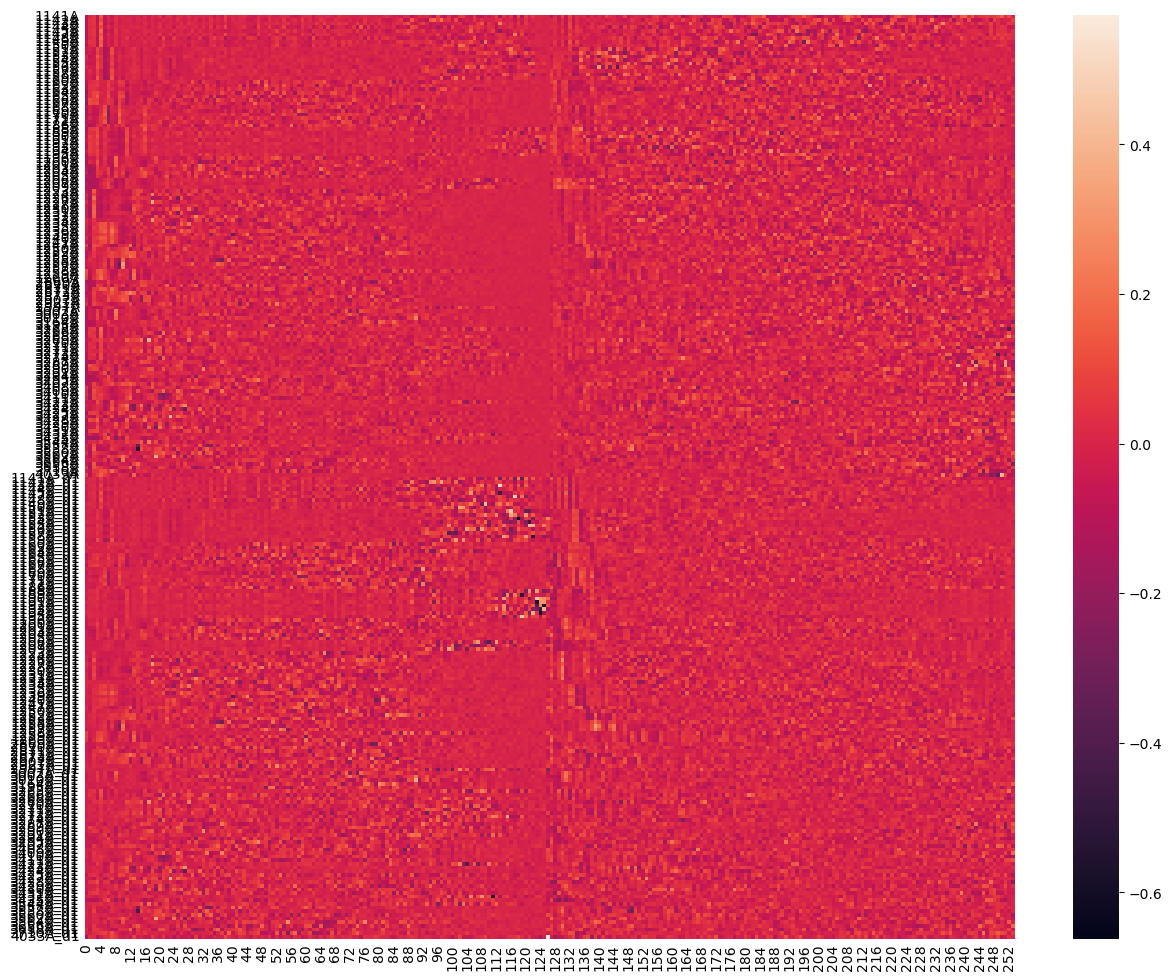

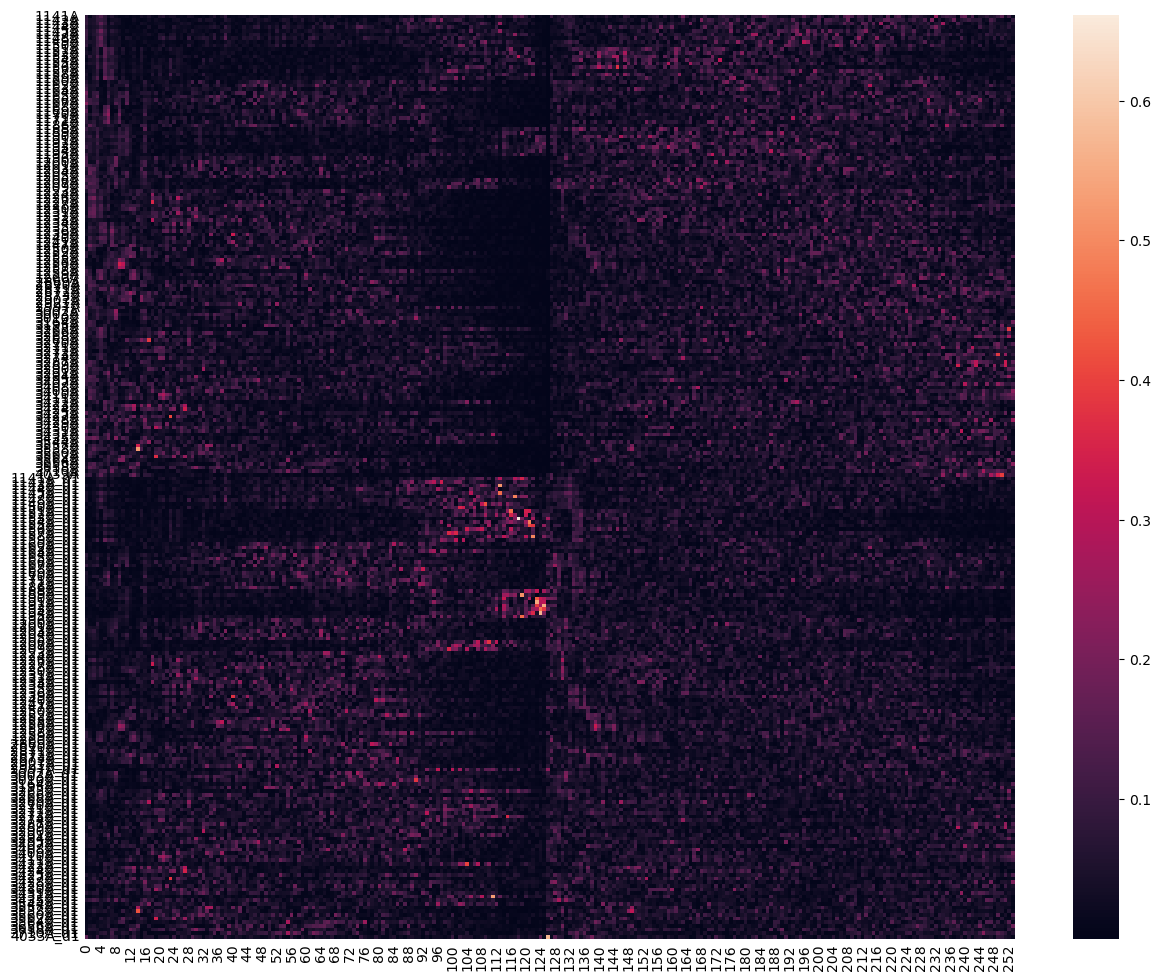

In [18]:
U_abs = np.abs(U)

plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U, yticklabels=new_names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U_abs, yticklabels=new_names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show() 

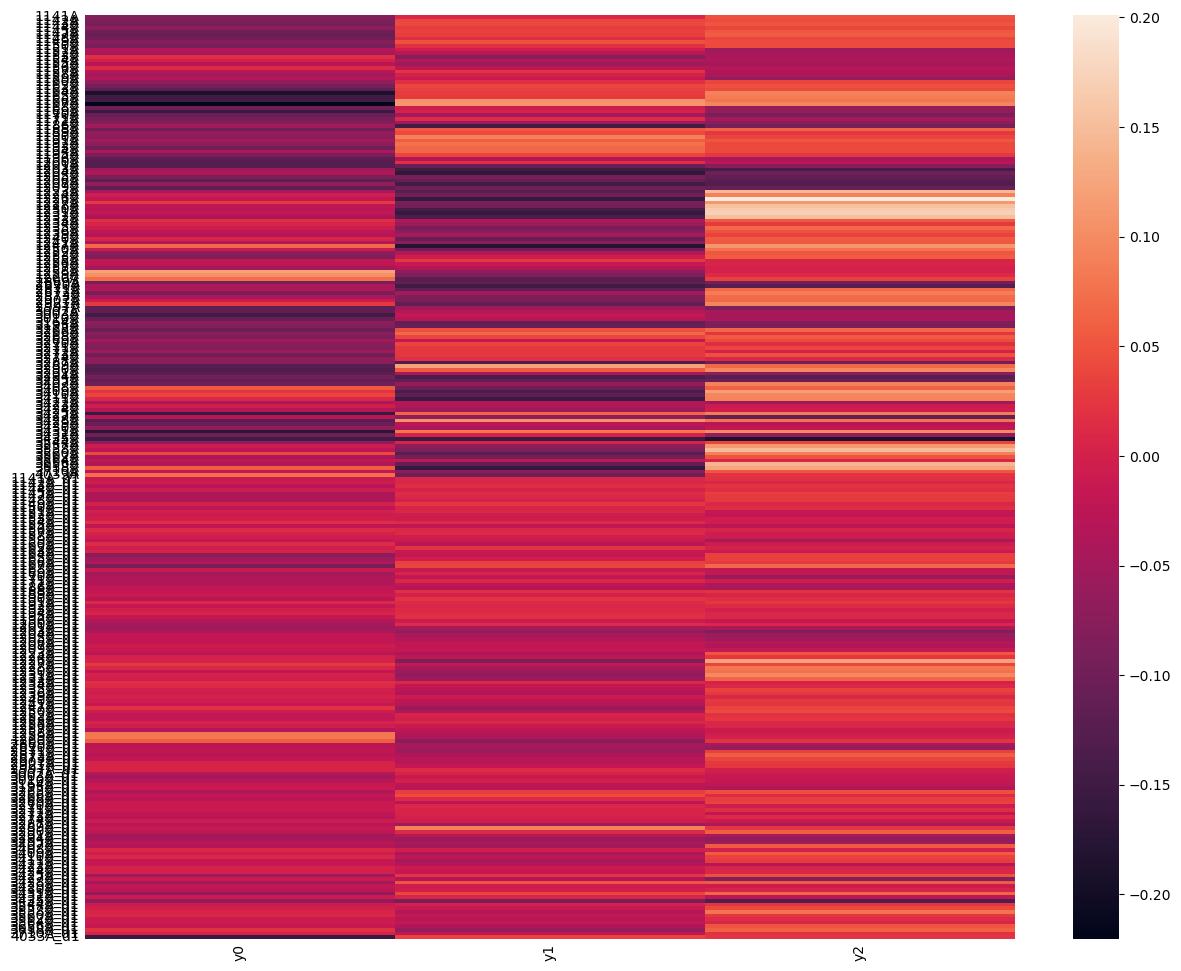

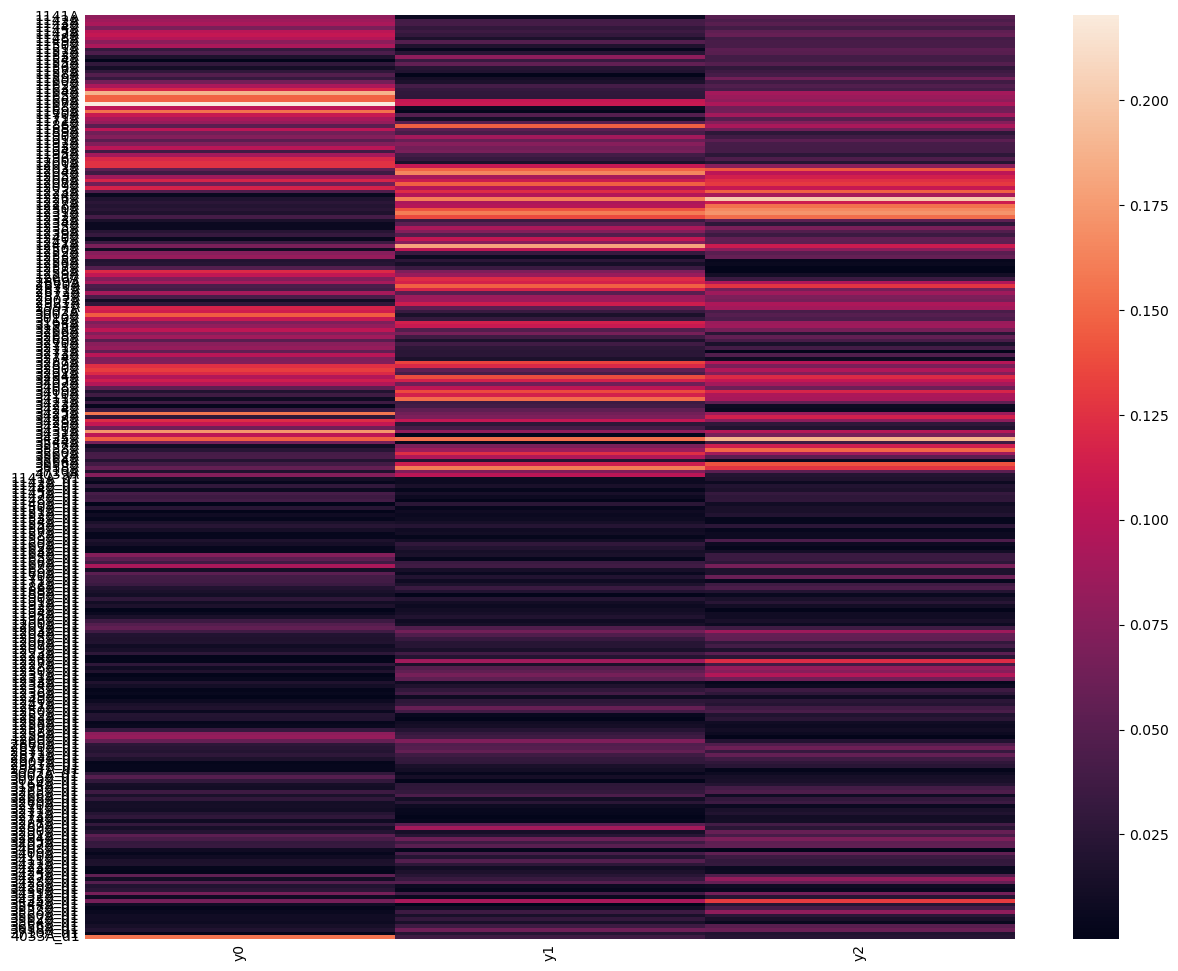

In [19]:
macro_name = [f'y{i}' for i in range(rank)]
coarse_grain_coff = U[:,:rank]

plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(coarse_grain_coff, yticklabels=new_names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(np.abs(coarse_grain_coff), yticklabels=new_names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()

In [25]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

cg_list = []

n = x_data.shape[1]
for i in range(n_delays+1):
    cg_list.append(U_abs[i*n:(i+1)*n, :rank])
len(cg_list)

2

In [36]:
for i,cg in enumerate(cg_list):
    plot_station(df, cg, delay=i)

In [28]:
coarse_grain_coff = U_abs[:, :rank]
print_equations(coarse_grain_coff, new_names, macro_name)

y0 = 0.0800 * 1141A + 0.0864 * 1142A + 0.0928 * 1143A + 0.0694 * 1144A + 0.1010 * 1145A + 0.1060 * 1147A + 0.0978 * 1148A + 0.0766 * 1149A + 0.0926 * 1150A + 0.0317 * 1151A + 0.0446 * 1152A + 0.0179 * 1153A + 0.0004 * 1154A + 0.0292 * 1155A + 0.0127 * 1156A + 0.0288 * 1157A + 0.0478 * 1158A + 0.0325 * 1159A + 0.0649 * 1160A + 0.0928 * 1162A + 0.1178 * 1163A + 0.1881 * 1164A + 0.1472 * 1165A + 0.1472 * 1166A + 0.2203 * 1167A + 0.1030 * 1168A + 0.1548 * 1169A + 0.1079 * 1170A + 0.0917 * 1171A + 0.0819 * 1172A + 0.0509 * 1186A + 0.1023 * 1188A + 0.0638 * 1189A + 0.0735 * 1190A + 0.0512 * 1191A + 0.0717 * 1192A + 0.1000 * 1193A + 0.0380 * 1194A + 0.0904 * 1195A + 0.1190 * 1196A + 0.1250 * 1200A + 0.1252 * 1201A + 0.0537 * 1203A + 0.0372 * 1204A + 0.0877 * 1205A + 0.1179 * 1206A + 0.0643 * 1207A + 0.1163 * 1209A + 0.0461 * 1223A + 0.0052 * 1224A + 0.0197 * 1226A + 0.0255 * 1227A + 0.0212 * 1228A + 0.0246 * 1230A + 0.0188 * 1231A + 0.0403 * 1232A + 0.0163 * 1233A + 0.0062 * 1234A + 0.0066 * 

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_39913/3056197561.py:9: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



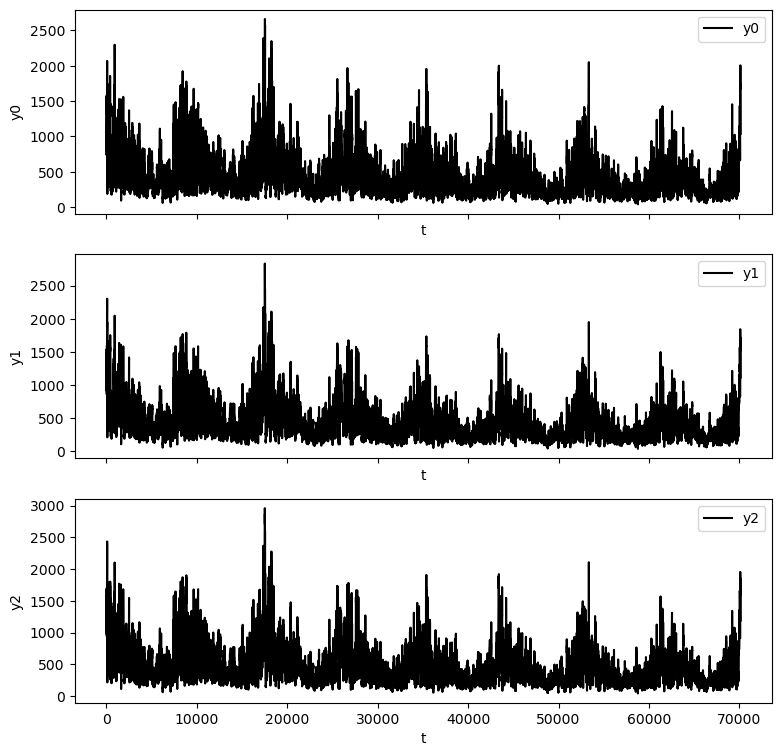

In [29]:
macro_data = H @ coarse_grain_coff
macro_dim = macro_data.shape[1]

fig, axs = plt.subplots(macro_dim, 1, sharex=True, figsize=(int(3*macro_dim), 9))
for i in range(macro_dim):
    axs[i].plot(macro_data[:, i], "k", label=f"y{i}")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=f"y{i}")
fig.show()

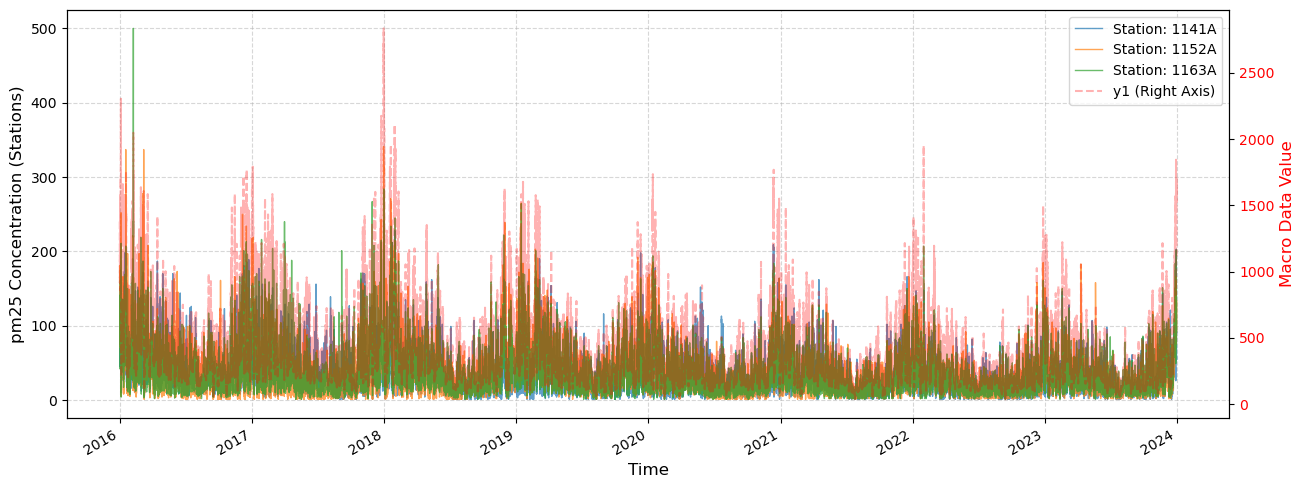

In [35]:
import matplotlib.pyplot as plt

# 1. 使用 subplots 创建画布和第一个坐标轴对象 (ax1)
fig, ax1 = plt.subplots(figsize=(15, 6))

# -------------------------------------------------
# 左侧 Y 轴 (ax1)：绘制各个站点的曲线
# -------------------------------------------------
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('pm25 Concentration (Stations)', fontsize=12) # 左轴标签
ax1.grid(True, linestyle='--', alpha=0.5)
times_final = times[n_delays:]
# 循环绘制选定站点的曲线 (画在 ax1 上)
for idx in selected_indices:
    station_name = stations[idx]
    # 提取数据 (保持原有逻辑)
    station_data = pm25.isel(station=idx).values[n_delays:]
    
    # 注意这里使用的是 ax1.plot
    ax1.plot(times_final, station_data, label=f'Station: {station_name}', alpha=0.7, linewidth=1)

# -------------------------------------------------
# 右侧 Y 轴 (ax2)：绘制最后一条宏观数据线
# -------------------------------------------------
ax2 = ax1.twinx()  # 关键步骤：创建共享X轴的第二个Y轴
ax2.set_ylabel('Macro Data Value', color='red', fontsize=12) # 右轴标签，设为红色以区分
ax2.tick_params(axis='y', labelcolor='red') # 设置右轴刻度颜色为红色

# 绘制最后一条线 (画在 ax2 上)
# 注意这里使用的是 ax2.plot
ax2.plot(times_final, macro_data[:, 1], color="red", linestyle='--', alpha=0.3, label=f"y{1} (Right Axis)")

# -------------------------------------------------
# 合并图例 (让两个轴的图例显示在一起)
# -------------------------------------------------
# 分别获取两个轴的图例句柄和标签
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
# 合并并显示
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

# 优化时间轴显示
fig.autofmt_xdate()

plt.show()

In [33]:
len(times)

70127